In [2]:

import json
import os
import time
from typing import Dict, List
from urllib import response


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as show
import requests
import torch
from requests import Response
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

from finrl.agents.portfolio_optimization.architectures import EIIE
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import (
    PortfolioOptimizationEnv,
)
from finrl.meta.preprocessor.preprocessors import GroupByScaler

# Закомментированные/неиспользуемые импорты (оставлены для справки)
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
# from utils import process_folder_data

In [1]:
import json
import os
import time
from typing import Dict, List
from urllib import response


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as show
import requests
import torch
from requests import Response
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.preprocessors import GroupByScaler
from model_finrl import EIIE,EI3, DRLAgent,PortfolioOptimizationEnv

# загрузка данных с moex

In [ ]:



sec_ids: List[str] =['ABIO',
 'AFKS',
 'AFLT',
 'AKRN',
 'AMEZ',
 'APTK',
 'BLNG',
 'BSPB',
 'CHMF',
 'CHMK',
 'ELFV',
 'FEES',
 'FESH',
 'GAZP',
 'GCHE',
 'HYDR',
 'INGR',
 'IRAO',
 'IRKT',
 'KMAZ',
 'LKOH',
 'LNZLP',
 'LNZL',
 'LSRG',
 'MAGN',
 'MGNT',
 'MRKC',
 'MRKK',
 'MRKP',
 'MRKU',
 'MRKV',
 'MRKY',
 'MRKZ',
 'MSNG',
 'MSRS',
 'MTLR',
 'MTSS',
 'MVID',
 'NKNCP',
 'NKNC',
 'NLMK',
 'NMTP',
 'NVTK',
 'OGKB',
 'PIKK',
 'PLZL',
 'RASP',
 'ROSN',
 'RTKMP',
 'RTKM',
 'SBERP',
 'SBER',
 'SNGSP',
 'SNGS',
 'SVAV',
 'TATNP',
 'TATN',
 'TGKA',
 'TGKB',
 'TRMK',
 'TRNFP',
 'VSMO',
 'VTBR']

for sec_id in sec_ids:
    url: str = f'https://iss.moex.com/iss/engines/stock/markets/shares/securities/{sec_id}/candles.json'
    params: dict = {
        'start': '0',
        'interval': '60',
        'limit': '500',
    }
    response = requests.get(url=url, params=params).json()
    df = pd.DataFrame()
    print(f'START {sec_id}')
    start_time = time.time()

    while len(response['candles']['data']) > 0:
        temp_df = pd.DataFrame(data=response['candles']['data'], columns=response['candles']['columns'])
        df = pd.concat([df, temp_df])

        params['start'] = str(int(params['start']) + int(params['limit']))
        response = requests.get(url=url, params=params).json()
        time.sleep(0.01)

    df['ticker'] = sec_id
    df.to_csv(f'./data/{sec_id}.csv', index=False, encoding='UTF-8')

    end_time = time.time()
    print(f'Time spent = {round(end_time - start_time, 2)} s')
    print(f'File size = {os.stat(f"./data/{sec_id}.csv").st_size} bytes')
    print(f'END {sec_id}')


START ABIO
Time spent = 8.79 s
File size = 2199934 bytes
END ABIO
START AFKS
Time spent = 14.67 s
File size = 3559449 bytes
END AFKS
START AFLT
Time spent = 14.68 s
File size = 3498791 bytes
END AFLT
START AKRN
Time spent = 12.78 s
File size = 2798155 bytes
END AKRN
START AMEZ
Time spent = 8.74 s
File size = 2147495 bytes
END AMEZ
START APTK
Time spent = 12.04 s
File size = 2835764 bytes
END APTK
START BLNG
Time spent = 11.5 s
File size = 2330961 bytes
END BLNG
START BSPB
Time spent = 12.47 s
File size = 2944411 bytes
END BSPB
START CHMF
Time spent = 14.44 s
File size = 3542741 bytes
END CHMF
START CHMK
Time spent = 8.56 s
File size = 1907598 bytes
END CHMK
START ELFV
Time spent = 2.16 s
File size = 645234 bytes
END ELFV
START FEES
Time spent = 15.71 s
File size = 3851537 bytes
END FEES
START FESH
Time spent = 12.63 s
File size = 2686222 bytes
END FESH
START GAZP
Time spent = 14.04 s
File size = 3745535 bytes
END GAZP
START GCHE
Time spent = 9.28 s
File size = 2372699 bytes
END GCHE
ST

# Ковертим с freq H на D

In [ ]:


def process_daily_data(input_folder, output_folder):
    """
    Обрабатывает CSV-файлы из указанной входной папки, преобразует данные в дневные интервалы
    и сохраняет результаты в выходную папку.
    
    Параметры:
    input_folder (str): Путь к папке с исходными CSV-файлами
    output_folder (str): Путь к папке для сохранения обработанных данных
    """
    # Создаем выходную папку, если она не существует
    os.makedirs(output_folder, exist_ok=True)
    
    # Обрабатываем каждый CSV-файл во входной папке
    for file in os.listdir(input_folder):
        if file.endswith(".csv"):
            # Читаем файл
            df = pd.read_csv(os.path.join(input_folder, file))
            
            # Преобразуем колонку 'begin' в datetime
            df['begin'] = pd.to_datetime(df['begin'])
            
            # Создаем колонку с датой (без времени)
            df['date'] = df['begin'].dt.date
            
            # Группируем по дате и агрегируем данные
            daily = df.groupby('date').agg({
                'open': 'first',
                'close': 'last',
                'high': 'max',
                'low': 'min',
                'value': 'sum',
                'volume': 'sum',
                'ticker': 'first'
            }).reset_index()
            
            # Сохраняем результат
            output_path = os.path.join(output_folder, file)
            daily.to_csv(output_path, index=False, encoding='utf-8')

# Пример использования
# process_daily_data("data", "data_daily")

# фильтруем данные отбираем по количеству пропусков 

In [3]:

def process_folder_data(folder_path,date_col='date', start_date='2010-01-01', threshold=0.01):
    """
    Обрабатывает все CSV-файлы в указанной папке, объединяет данные,
    фильтрует по дате и удаляет столбцы с пропусками.

    Параметры:
    - folder_path: путь к папке с CSV-файлами
    - start_date: начальная дата для фильтрации (по умолчанию '2010-01-01')
    - threshold: максимально допустимая доля пропусков (по умолчанию 0.01)

    Возвращает:
    - Объединенный и очищенный DataFrame
    """
    
    data_frames = []

    # Обработка каждого CSV-файла
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            
            # Загрузка и преобразование данных
            df = pd.read_csv(file_path)
            df['datetime'] = pd.to_datetime(df[date_col])
            df['tic'] = file_name.replace('.csv', '')
            
            # Преобразование в широкий формат
            df_pivot = df.pivot(index='datetime', columns='tic', values=['close','high','low','open','volume'])
            data_frames.append(df_pivot)

    # Объединение данных
    merged_data = pd.concat(data_frames, axis=1)
    
    # Фильтрация по дате
    merged_data = merged_data.loc[start_date:]
    
    # Удаление столбцов с пропусками
    null_percent = merged_data.isna().mean()
    columns_to_drop = null_percent[null_percent >= threshold].index
    merged_data = merged_data.drop(columns=columns_to_drop)

    return merged_data


# Вызов функции
result = process_folder_data(
    folder_path="data_daily",
    date_col='date',
    start_date='2010-01-01',
    threshold=0.03
)


print(result.head())
# Вызов функции

             close    high     low    open   volume   close    high     low  \
tic           ABIO    ABIO    ABIO    ABIO     ABIO    AFKS    AFKS    AFKS   
datetime                                                                      
2011-11-17  11.600  11.779  11.383  11.406  20200.0  23.500  23.699  22.900   
2011-11-18  11.605  11.848  11.237  11.237  89500.0  22.923  23.289  22.880   
2011-11-21  11.167  11.675  11.050  11.675  53700.0  21.750  22.870  21.700   
2011-11-22  10.965  11.267  10.700  11.101  81200.0  21.902  22.298  21.889   
2011-11-23  10.770  11.099  10.640  10.774  85000.0  23.750  23.750  21.902   

              open     volume  ...   close    high     low    open  volume  \
tic           AFKS       AFKS  ...    VSMO    VSMO    VSMO    VSMO    VSMO   
datetime                       ...                                           
2011-11-17  23.699  2000800.0  ...  5010.0  5049.9  4550.0  4799.8  8884.0   
2011-11-18  23.121  1176700.0  ...  4903.8  5010.0  483

In [3]:
result.isna().sum().sort_values(ascending=False).head(20)

        tic 
high    AMEZ    58
close   AMEZ    58
low     AMEZ    58
volume  AMEZ    58
open    AMEZ    58
volume  MRKU    37
close   MRKU    37
high    MRKU    37
low     MRKU    37
open    MRKU    37
volume  NKNC    31
open    NKNC    31
low     NKNC    31
high    NKNC    31
close   NKNC    31
        ABIO    29
high    ABIO    29
volume  ABIO    29
open    ABIO    29
low     ABIO    29
dtype: int64

In [4]:

X=result.fillna(method='ffill')

X

C:\Users\bodya\AppData\Local\Temp\ipykernel_15556\767397286.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X=result.fillna(method='ffill')


,close,high,low,open,volume,close,high,low,open,volume,...,close,high,low,open,volume,close,high,low,open,volume
tic,ABIO,ABIO,ABIO,ABIO,ABIO,AFKS,AFKS,AFKS,AFKS,AFKS,...,VSMO,VSMO,VSMO,VSMO,VSMO,VTBR,VTBR,VTBR,VTBR,VTBR
datetime,,,,,,,,,,,,,,,,,,,,,
2011-11-17,11.600,11.779,11.383,11.406,20200.0,23.500,23.699,22.900,23.699,2000800.0,...,5010.0,5049.9,4550.0,4799.8,8884.0,345.40,354.80,340.15,350.55,3.532900e+10
2011-11-18,11.605,11.848,11.237,11.237,89500.0,22.923,23.289,22.880,23.121,1176700.0,...,4903.8,5010.0,4836.8,4836.8,1459.0,340.00,344.05,338.65,340.90,2.405373e+10
2011-11-21,11.167,11.675,11.050,11.675,53700.0,21.750,22.870,21.700,22.870,1273800.0,...,4699.5,4880.5,4600.0,4820.6,3319.0,316.15,337.45,315.75,336.60,3.465120e+10
2011-11-22,10.965,11.267,10.700,11.101,81200.0,21.902,22.298,21.889,21.889,2180300.0,...,4747.1,4848.7,4610.5,4702.1,1161.0,318.50,324.20,313.60,317.50,2.480269e+10
2011-11-23,10.770,11.099,10.640,10.774,85000.0,23.750,23.750,21.902,22.000,6155600.0,...,4710.0,4800.0,4599.9,4653.7,1485.0,313.50,321.80,311.25,312.50,3.693631e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14,83.720,86.520,83.380,86.140,136610.0,14.919,15.569,14.694,15.450,165757700.0,...,31120.0,32560.0,30760.0,32100.0,1618.0,75.50,78.29,75.09,78.20,6.280206e+07
2025-04-15,83.740,84.800,83.100,83.540,132450.0,14.736,15.035,14.300,14.859,124502400.0,...,31400.0,31700.0,31060.0,31280.0,734.0,77.10,77.47,75.23,75.88,7.118670e+07


In [5]:
df_stacked_X_train=X.stack(level='tic')
df_flat_X_train = df_stacked_X_train.reset_index()

df_flat_X_train

C:\Users\bodya\AppData\Local\Temp\ipykernel_15556\120679396.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_stacked_X_train=X.stack(level='tic')


,datetime,tic,close,high,low,open,volume
0,2011-11-17,ABIO,11.600000,11.779000,11.383000,11.406000,20200.0
1,2011-11-17,AFKS,23.500000,23.699000,22.900000,23.699000,2000800.0
2,2011-11-17,AFLT,51.000000,51.520000,50.500000,51.500000,883800.0
3,2011-11-17,AKRN,1410.000000,1430.000000,1351.000000,1410.000000,70290.0
4,2011-11-17,AMEZ,9.280000,9.779000,9.120000,9.501000,96200.0
...,...,...,...,...,...,...,...
206236,2025-04-18,TGKB,0.006695,0.006725,0.006595,0.006625,112000000.0
206237,2025-04-18,TRMK,108.100000,108.980000,107.400000,108.960000,558350.0
206238,2025-04-18,TRNFP,1291.800000,1303.400000,1283.000000,1302.000000,320883.0
206239,2025-04-18,VSMO,31740.000000,31920.000000,31640.000000,31800.000000,177.0


In [6]:
df_flat_X_train['datetime']=pd.to_datetime(df_flat_X_train['datetime'])

In [7]:
df_flat_X_train.groupby("tic").count()

,datetime,close,high,low,open,volume
tic,,,,,,
ABIO,3381,3381,3381,3381,3381,3381
AFKS,3381,3381,3381,3381,3381,3381
AFLT,3381,3381,3381,3381,3381,3381
AKRN,3381,3381,3381,3381,3381,3381
AMEZ,3381,3381,3381,3381,3381,3381
...,...,...,...,...,...,...
TGKB,3381,3381,3381,3381,3381,3381
TRMK,3381,3381,3381,3381,3381,3381
TRNFP,3381,3381,3381,3381,3381,3381


# чекаем на факт консолидации 

In [8]:


df_flat_X_train['prev_close'] = df_flat_X_train.groupby('tic')['close'].shift(1)
df_flat_X_train['close_jump'] = df_flat_X_train['close'] / df_flat_X_train['prev_close']

df_flat_X_train['prev_open'] = df_flat_X_train.groupby('tic')['open'].shift(1)
df_flat_X_train['open_jump'] = df_flat_X_train['open'] / df_flat_X_train['prev_open']
# Считаем, что обратный сплит — если цена выросла более чем в 2 раза за 1 день
reverse_splits_close = df_flat_X_train[df_flat_X_train['close_jump'] > 2]
reverse_splits_open = df_flat_X_train[df_flat_X_train['open_jump'] > 2]
print("Возможные обратные сплиты close:")
print(reverse_splits_close[['datetime', 'tic', 'prev_close', 'close', 'close_jump']])
print("Возможные обратные сплиты open:")
print(reverse_splits_open[['datetime', 'tic', 'prev_open', 'open', 'open_jump']])
df_flat_X_train.drop(columns=['prev_close', 'prev_open'], inplace=True)
df_flat_X_train.drop(columns=['close_jump', 'open_jump'], inplace=True)


Возможные обратные сплиты close:
        datetime   tic  prev_close    close  close_jump
47459 2014-12-18  AFKS      6.6300  13.6000    2.051282
48632 2015-01-20  IRAO      0.0071   0.7615  107.253521
Возможные обратные сплиты open:
        datetime   tic  prev_open   open   open_jump
47520 2014-12-19  AFKS   7.300000  14.75    2.020548
48632 2015-01-20  IRAO   0.006749   0.80  118.536079


# скейлим данные 

In [9]:

valid_columns = ['open', 'high', 'low', 'close', 'volume','tic'] 
gbsclr=GroupByScaler(by="tic", scaler=MaxAbsScaler)
portfolio_norm_df = gbsclr.fit_transform(df_flat_X_train[valid_columns])
portfolio_norm_df['date']=df_flat_X_train['datetime']

In [67]:
TIME_WINDOW=16

INITIAL_FEATURES=5 # Равен колличеству OHLCV
EPOCH=6
BATCH_SIZE=512 # Размер батча и размер памяти PVM
LR=0.01
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# сплитуем данные 

In [68]:
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low","volume", "open"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] < "2022-07-01")]
df_portfolio_test = df_portfolio[(df_portfolio["date"] >= "2022-07-01") ]


In [14]:
df_portfolio_test

,date,tic,close,high,low,volume,open
162016,2022-07-01,ABIO,0.377743,0.326554,0.390629,0.004989,0.380057
162017,2022-07-01,AFKS,0.308738,0.314286,0.298633,0.081202,0.296298
162018,2022-07-01,AFLT,0.118844,0.122667,0.120046,0.031826,0.122215
162019,2022-07-01,AKRN,0.690855,0.632323,0.799716,0.025549,0.640211
162020,2022-07-01,AMEZ,0.113683,0.111613,0.106054,0.029054,0.097539
...,...,...,...,...,...,...,...
206236,2025-04-18,TGKB,0.437868,0.388167,0.454671,0.000431,0.418377
206237,2025-04-18,TRMK,0.398893,0.392268,0.409205,0.012071,0.402661
206238,2025-04-18,TRNFP,0.559221,0.552991,0.582917,0.030068,0.563636
206239,2025-04-18,VSMO,0.495937,0.486734,0.523841,0.002887,0.510106


In [15]:
df_portfolio_train

,date,tic,close,high,low,volume,open
0,2011-11-17,ABIO,0.077858,0.066548,0.079601,0.000628,0.075025
1,2011-11-17,AFKS,0.488576,0.483653,0.481598,0.003037,0.490703
2,2011-11-17,AFLT,0.226667,0.228978,0.232987,0.005598,0.236618
3,2011-11-17,AKRN,0.052203,0.048148,0.060023,0.325986,0.049648
4,2011-11-17,AMEZ,0.049716,0.048040,0.049297,0.000923,0.046674
...,...,...,...,...,...,...,...
162011,2022-06-30,TGKB,0.241334,0.230303,0.228887,0.007684,0.248816
162012,2022-06-30,TRMK,0.205609,0.212440,0.206050,0.014978,0.211678
162013,2022-06-30,TRNFP,0.517100,0.543487,0.530214,0.000199,0.541991
162014,2022-06-30,VSMO,0.906250,0.914913,0.929470,0.019705,0.933590


In [69]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=1000000,
        comission_fee_pct=0.0025,
        time_window=TIME_WINDOW,
        reward_scaling=0.01,
        #return_last_action=True,
        features=["close", "high", "low","volume","open"],
        normalize_df=None
    )

environment_test = PortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=1000000,
    comission_fee_pct=0.0025,
    reward_scaling=0.01,
    time_window=TIME_WINDOW,
    features=["close", "high", "low","volume","open"],
    normalize_df=None
)

In [70]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": LR,
    "policy": EIIE,
    #'validation_env':environment_test,
    'batch_size':BATCH_SIZE
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 4,
    "initial_features":INITIAL_FEATURES,
    "time_window": TIME_WINDOW,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [71]:
training_model=DRLAgent.train_model(model, episodes=EPOCH,)

  0%|          | 0/6 [00:00<?, ?it/s]

Initial portfolio value:1000000
Final portfolio value: 5523187.5
Final accumulative portfolio value: 5.5231875
Maximum DrawDown: -0.4338383533934803
Sharpe ratio: 0.4511785775661884


 17%|█▋        | 1/6 [03:01<15:07, 181.41s/it]

Initial portfolio value:1000000
Final portfolio value: 5696951.0
Final accumulative portfolio value: 5.696951
Maximum DrawDown: -0.43388314607520084
Sharpe ratio: 0.4482171890314152


 33%|███▎      | 2/6 [06:05<12:10, 182.72s/it]

Initial portfolio value:1000000
Final portfolio value: 5767475.5
Final accumulative portfolio value: 5.7674755
Maximum DrawDown: -0.4336546729093913
Sharpe ratio: 0.44861304378325473


 50%|█████     | 3/6 [08:53<08:49, 176.35s/it]

Initial portfolio value:1000000
Final portfolio value: 5880745.0
Final accumulative portfolio value: 5.880745
Maximum DrawDown: -0.43318115299268245
Sharpe ratio: 0.4495568865272963


 67%|██████▋   | 4/6 [11:40<05:45, 172.70s/it]

Initial portfolio value:1000000
Final portfolio value: 6040080.0
Final accumulative portfolio value: 6.04008
Maximum DrawDown: -0.4317891529448218
Sharpe ratio: 0.4530357077078887


 83%|████████▎ | 5/6 [14:27<02:50, 170.53s/it]

Initial portfolio value:1000000
Final portfolio value: 6402099.0
Final accumulative portfolio value: 6.402099
Maximum DrawDown: -0.42974775415637734
Sharpe ratio: 0.45606136357415683


100%|██████████| 6/6 [17:16<00:00, 172.72s/it]


In [ ]:
#torch.save(model.train_policy.state_dict(), f"policy_EIIE_batch_{BATCH_SIZE}_window_{TIME_WINDOW}_epoch_{EPOCH}.pt")

In [73]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "test": {},
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device,initial_features=5,k_size=4)
policy.load_state_dict(torch.load(f"policy_EIIE_batch_{BATCH_SIZE}_window_{TIME_WINDOW}_epoch_{EPOCH}.pt"))

# test
DRLAgent.DRL_validation(model, environment_test,policy=policy)
EIIE_results["test"]["value"] = environment_test._asset_memory["final"]


C:\Users\bodya\AppData\Local\Temp\ipykernel_15556\1092881883.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(f"policy_EIIE_batch_{BATCH

Initial portfolio value:1000000
Final portfolio value: 1699009.125
Final accumulative portfolio value: 1.699009125
Maximum DrawDown: -0.40515655818132246
Sharpe ratio: 0.9330713568523546


<Axes: title={'center': 'EIIE test'}>

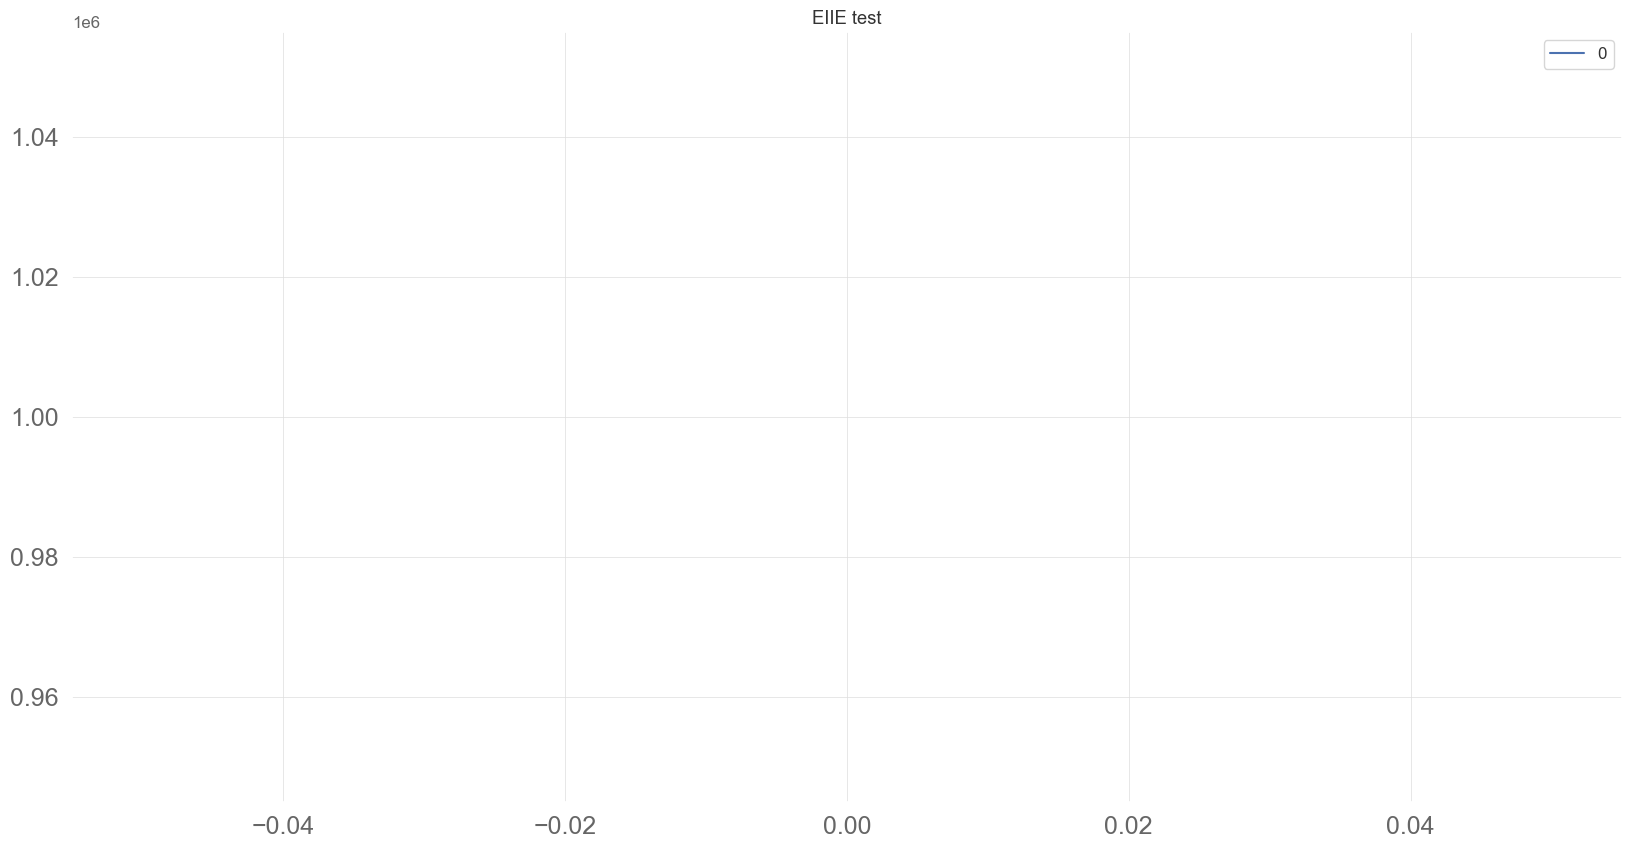

In [15]:
pd.DataFrame(EIIE_results["training"]).plot(title="EIIE test", figsize=(20, 10), fontsize=18)

<Axes: title={'center': 'EIIE test'}>

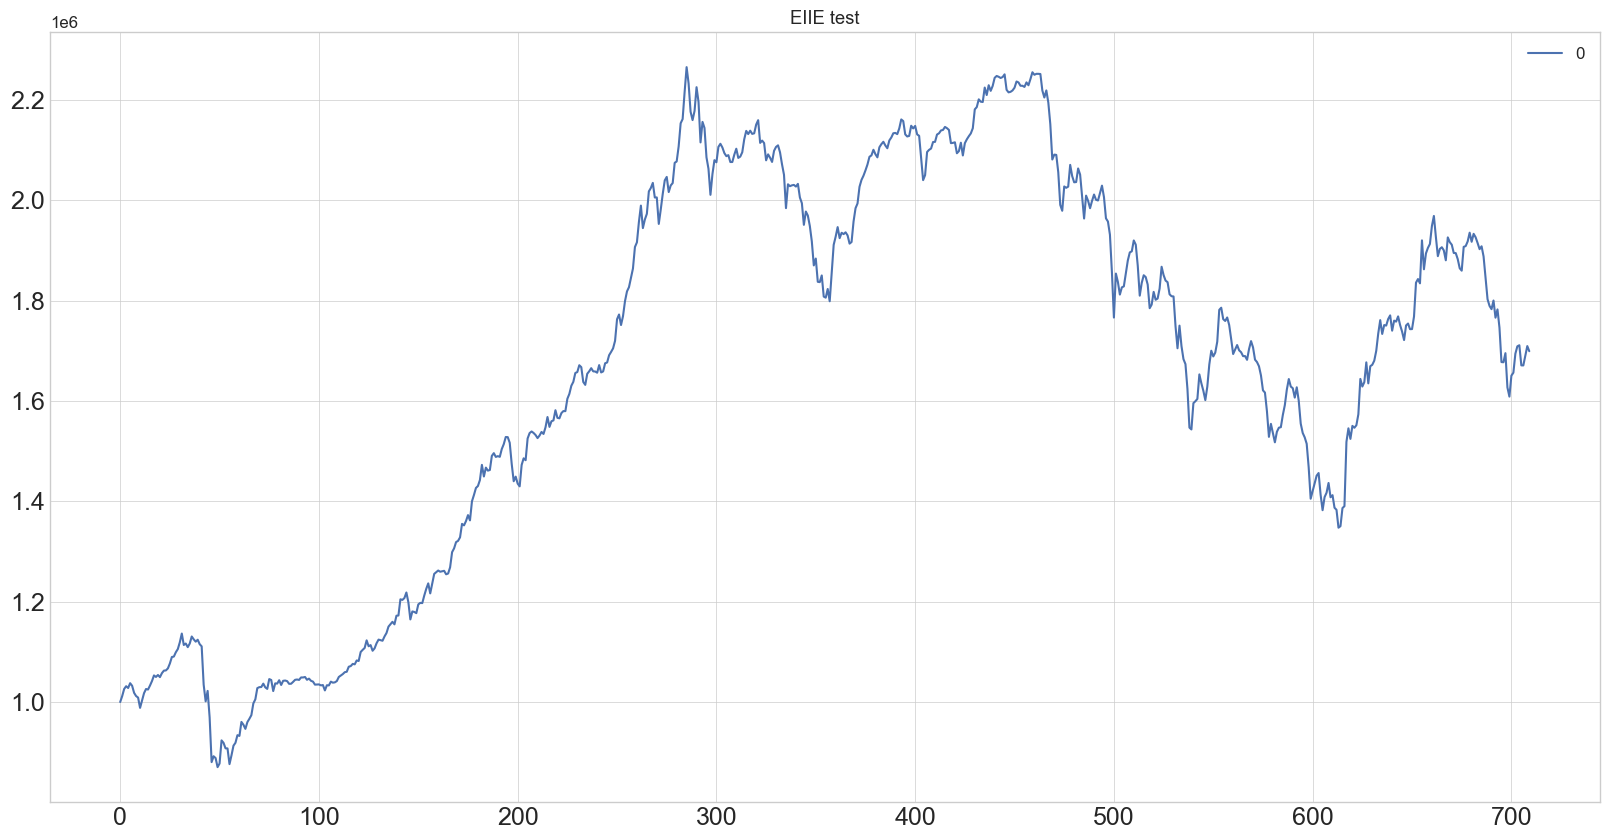

In [74]:
pd.DataFrame(EIIE_results["test"]["value"]).plot(title="EIIE test", figsize=(20, 10), fontsize=18)

# Пост аналитика 

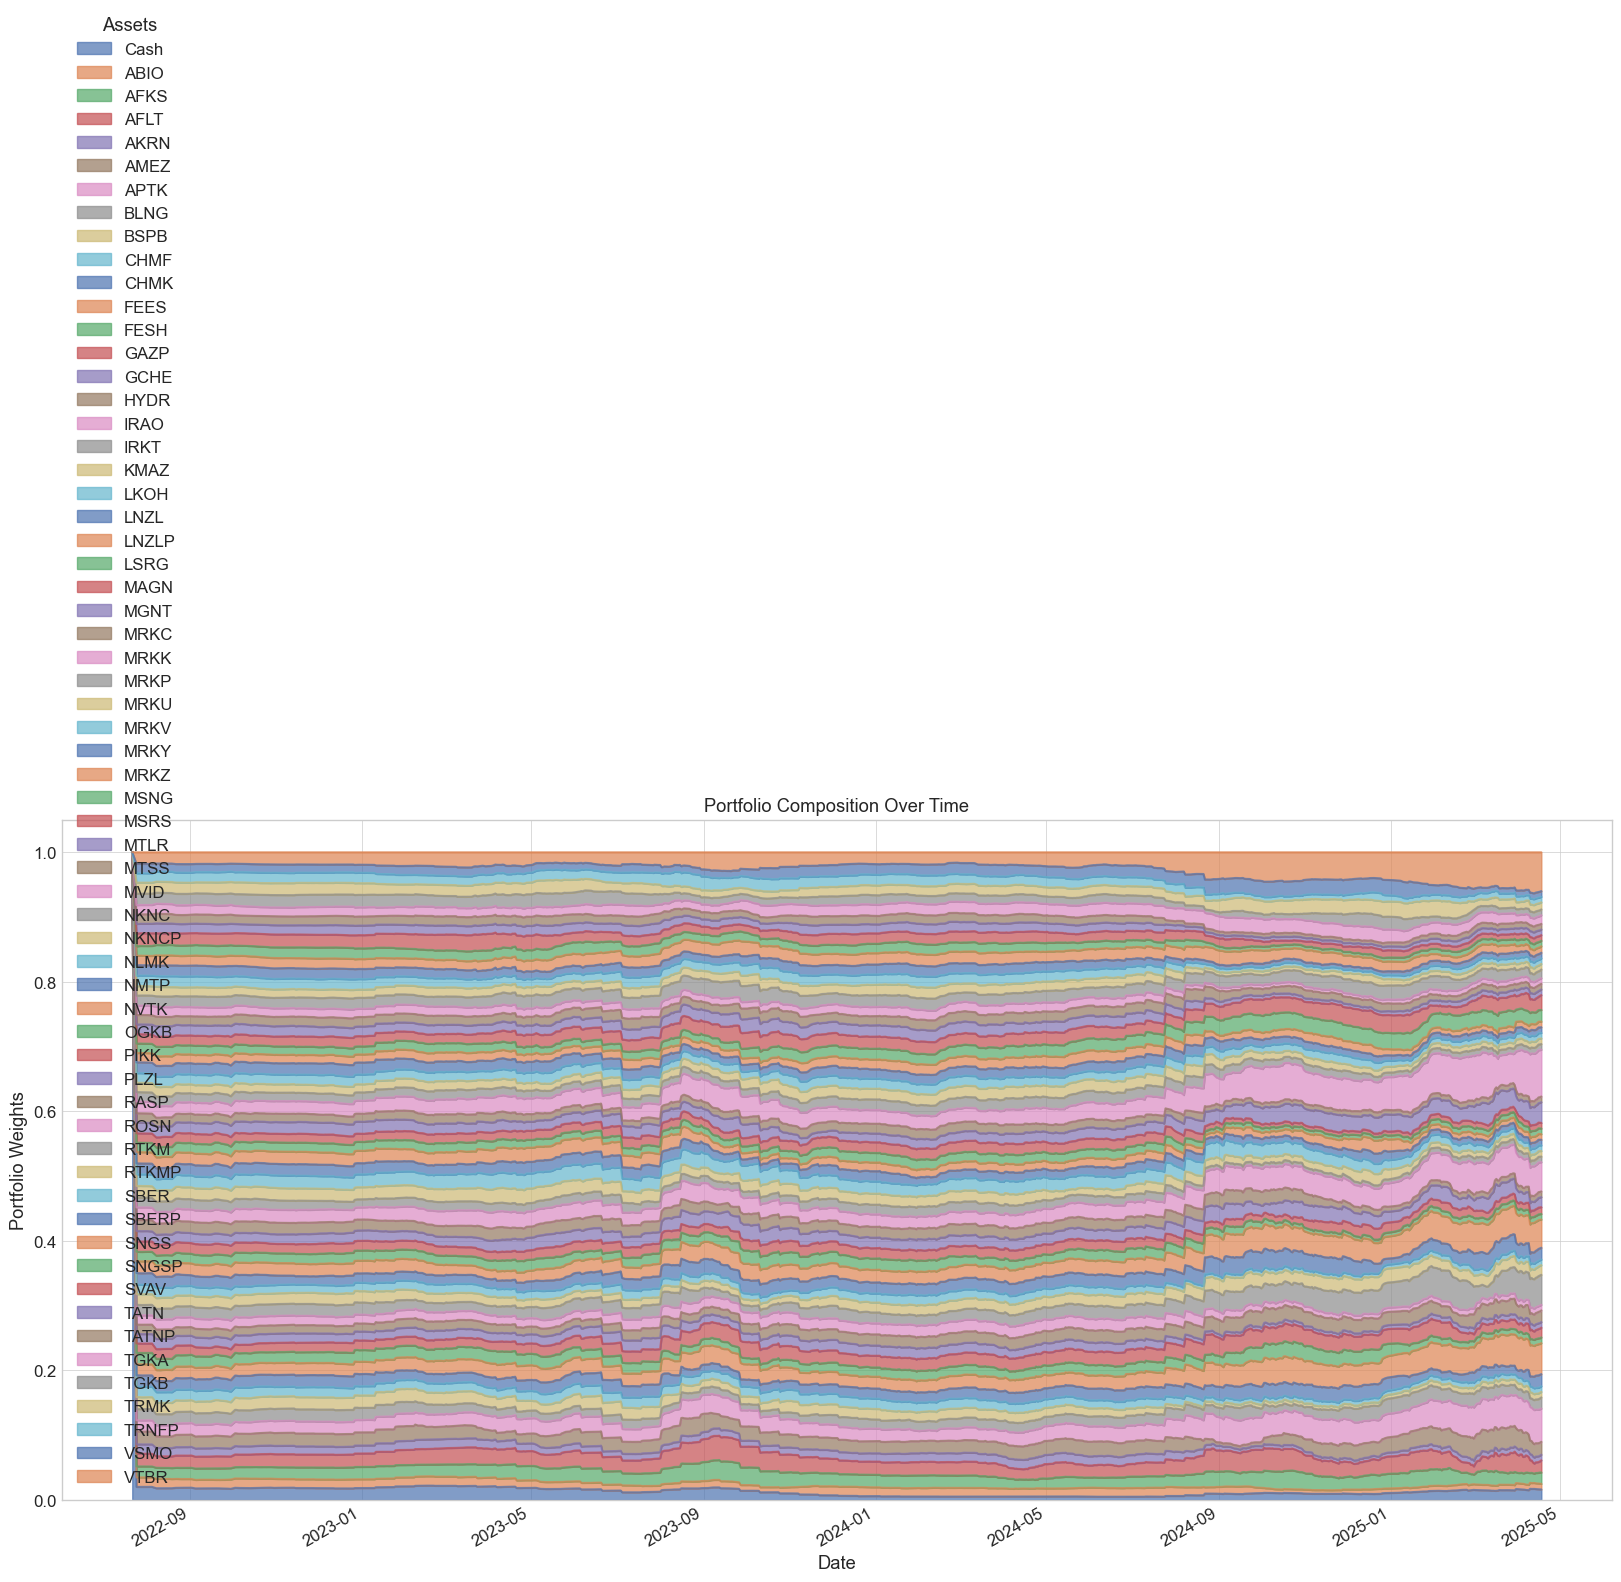

In [90]:
actions_memory = environment_test._actions_memory  

actions_df = pd.DataFrame(actions_memory, columns=["Cash"] + list(environment._tic_list))

# Добавление дат
actions_df["Date"] = environment_test._date_memory
actions_df.set_index("Date", inplace=True)

# Построение графика областей
actions_df.plot(kind="area", stacked=True, figsize=(20, 10), alpha=0.7)

# Настройка графика
plt.title("Portfolio Composition Over Time")
plt.ylabel("Portfolio Weights")
plt.xlabel("Date")
plt.legend(title="Assets")
plt.show()

## Дискретизация акций распределение ==> количетво акций на покупку

In [91]:
# 
# Получаем цены на каждую дату для каждой акции
prices = df_flat_X_train.pivot(index='datetime', columns='tic', values='close')

# Предполагаем, что сумма портфеля постоянна (например, 100000)
portfolio_value = 100000

# Берём только акции (без Cash)
stock_columns = [col for col in actions_df.columns if col != "Cash"]

# Для каждой даты и каждой акции считаем количество купленных акций
shares = (actions_df[stock_columns] * portfolio_value) / prices[stock_columns]
shares = shares.fillna(0)
shares_discrete = np.floor(shares)


print(shares_discrete.head())


            ABIO  AFKS  AFLT  AKRN  AMEZ  APTK  BLNG  BSPB  CHMF  CHMK  ...  \
2011-11-17   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2011-11-18   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2011-11-21   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2011-11-22   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2011-11-23   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

            SNGSP  SVAV  TATN  TATNP  TGKA  TGKB  TRMK  TRNFP  VSMO  VTBR  
2011-11-17    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  
2011-11-18    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  
2011-11-21    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  
2011-11-22    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  
2011-11-23    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  

[5 rows x 61 columns]


In [92]:
prices

tic,ABIO,AFKS,AFLT,AKRN,AMEZ,APTK,BLNG,BSPB,CHMF,CHMK,...,SNGSP,SVAV,TATN,TATNP,TGKA,TGKB,TRMK,TRNFP,VSMO,VTBR
datetime,,,,,,,,,,,,,,,,,,,,,
2011-11-17,11.600,23.500,51.00,1410.0,9.280,48.990,11.650,93.88,428.2,3521.0,...,16.299,354.3,157.05,97.21,0.010397,0.003609,90.50,474.70,5010.0,345.40
2011-11-18,11.605,22.923,50.74,1374.1,9.006,48.980,11.456,89.00,426.1,3492.0,...,16.330,356.0,154.14,95.01,0.010272,0.003560,88.18,463.58,4903.8,340.00
2011-11-21,11.167,21.750,50.00,1395.0,8.809,47.490,10.980,82.99,395.5,3336.0,...,15.770,334.2,143.70,93.00,0.009991,0.003410,82.68,460.55,4699.5,316.15
2011-11-22,10.965,21.902,49.90,1438.0,8.806,47.000,10.850,81.25,404.1,3344.0,...,15.869,334.9,148.26,96.71,0.010087,0.003437,83.70,462.80,4747.1,318.50
2011-11-23,10.770,23.750,50.00,1480.3,8.978,46.880,10.900,81.00,406.0,3401.0,...,15.950,329.0,146.67,96.00,0.010079,0.003480,81.51,464.04,4710.0,313.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14,83.720,14.919,68.69,16250.0,68.050,10.310,14.370,383.46,1035.0,5100.0,...,51.700,666.5,686.40,648.60,0.006698,0.006650,110.44,1236.80,31120.0,75.50
2025-04-15,83.740,14.736,69.35,16236.0,68.050,10.248,14.430,384.20,1042.0,5125.0,...,52.030,664.0,684.10,646.20,0.006564,0.006620,110.14,1267.20,31400.0,77.10
2025-04-16,83.520,14.927,69.35,16400.0,68.050,10.358,14.760,388.30,1041.4,5310.0,...,52.305,667.5,685.90,648.00,0.006598,0.006680,110.10,1286.60,31800.0,79.73


In [93]:
variance=shares_discrete.loc['2022-10-01':].var()
variance_filter=variance[variance> 0.0001].index
variance[variance> 0.0001].sort_values(ascending=False).head(20)

TGKB    3.119830e+10
TGKA    3.611053e+09
MRKZ    6.055858e+08
MRKV    3.969006e+08
MRKY    2.073725e+08
FEES    2.067405e+08
MRKU    1.146704e+07
OGKB    4.185238e+06
MRKP    3.899808e+06
MRKC    2.813425e+06
HYDR    1.096914e+06
MSRS    1.067361e+05
MSNG    2.915071e+04
APTK    1.009792e+04
NMTP    9.626525e+03
IRAO    8.830815e+03
MRKK    3.708885e+03
BLNG    2.812033e+03
IRKT    1.817505e+03
AFKS    1.162963e+03
dtype: float64

In [94]:
shares_discrete.loc['2022-10-01':][variance_filter]

,ABIO,AFKS,AFLT,AMEZ,APTK,BLNG,BSPB,CHMF,FEES,FESH,...,SNGS,SNGSP,SVAV,TATN,TATNP,TGKA,TGKB,TRMK,TRNFP,VTBR
2022-10-03,26.0,156.0,81.0,77.0,155.0,217.0,23.0,2.0,22075.0,53.0,...,80.0,67.0,11.0,3.0,3.0,200509.0,610386.0,29.0,1.0,22.0
2022-10-04,26.0,159.0,83.0,78.0,156.0,212.0,23.0,2.0,22232.0,49.0,...,82.0,67.0,10.0,3.0,3.0,207366.0,627510.0,30.0,1.0,23.0
2022-10-05,28.0,163.0,81.0,78.0,155.0,219.0,24.0,2.0,22409.0,50.0,...,82.0,66.0,10.0,3.0,3.0,207697.0,628469.0,29.0,2.0,23.0
2022-10-06,25.0,166.0,82.0,78.0,155.0,215.0,24.0,2.0,22854.0,51.0,...,84.0,67.0,10.0,3.0,3.0,206722.0,631670.0,30.0,2.0,23.0
2022-10-07,26.0,174.0,85.0,81.0,160.0,234.0,24.0,2.0,23475.0,50.0,...,89.0,70.0,10.0,3.0,3.0,204008.0,659370.0,31.0,2.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14,10.0,106.0,23.0,30.0,504.0,107.0,2.0,0.0,68757.0,16.0,...,43.0,17.0,1.0,1.0,1.0,187535.0,140830.0,10.0,0.0,82.0
2025-04-15,10.0,109.0,23.0,29.0,505.0,110.0,2.0,0.0,69020.0,16.0,...,42.0,17.0,1.0,1.0,1.0,192921.0,139842.0,10.0,0.0,80.0
2025-04-16,10.0,110.0,24.0,29.0,499.0,109.0,2.0,0.0,70100.0,16.0,...,42.0,16.0,1.0,1.0,1.0,194414.0,136422.0,10.0,0.0,77.0
2025-04-17,10.0,111.0,24.0,29.0,497.0,115.0,2.0,0.0,67998.0,14.0,...,41.0,16.0,1.0,1.0,1.0,193801.0,135649.0,10.0,0.0,73.0


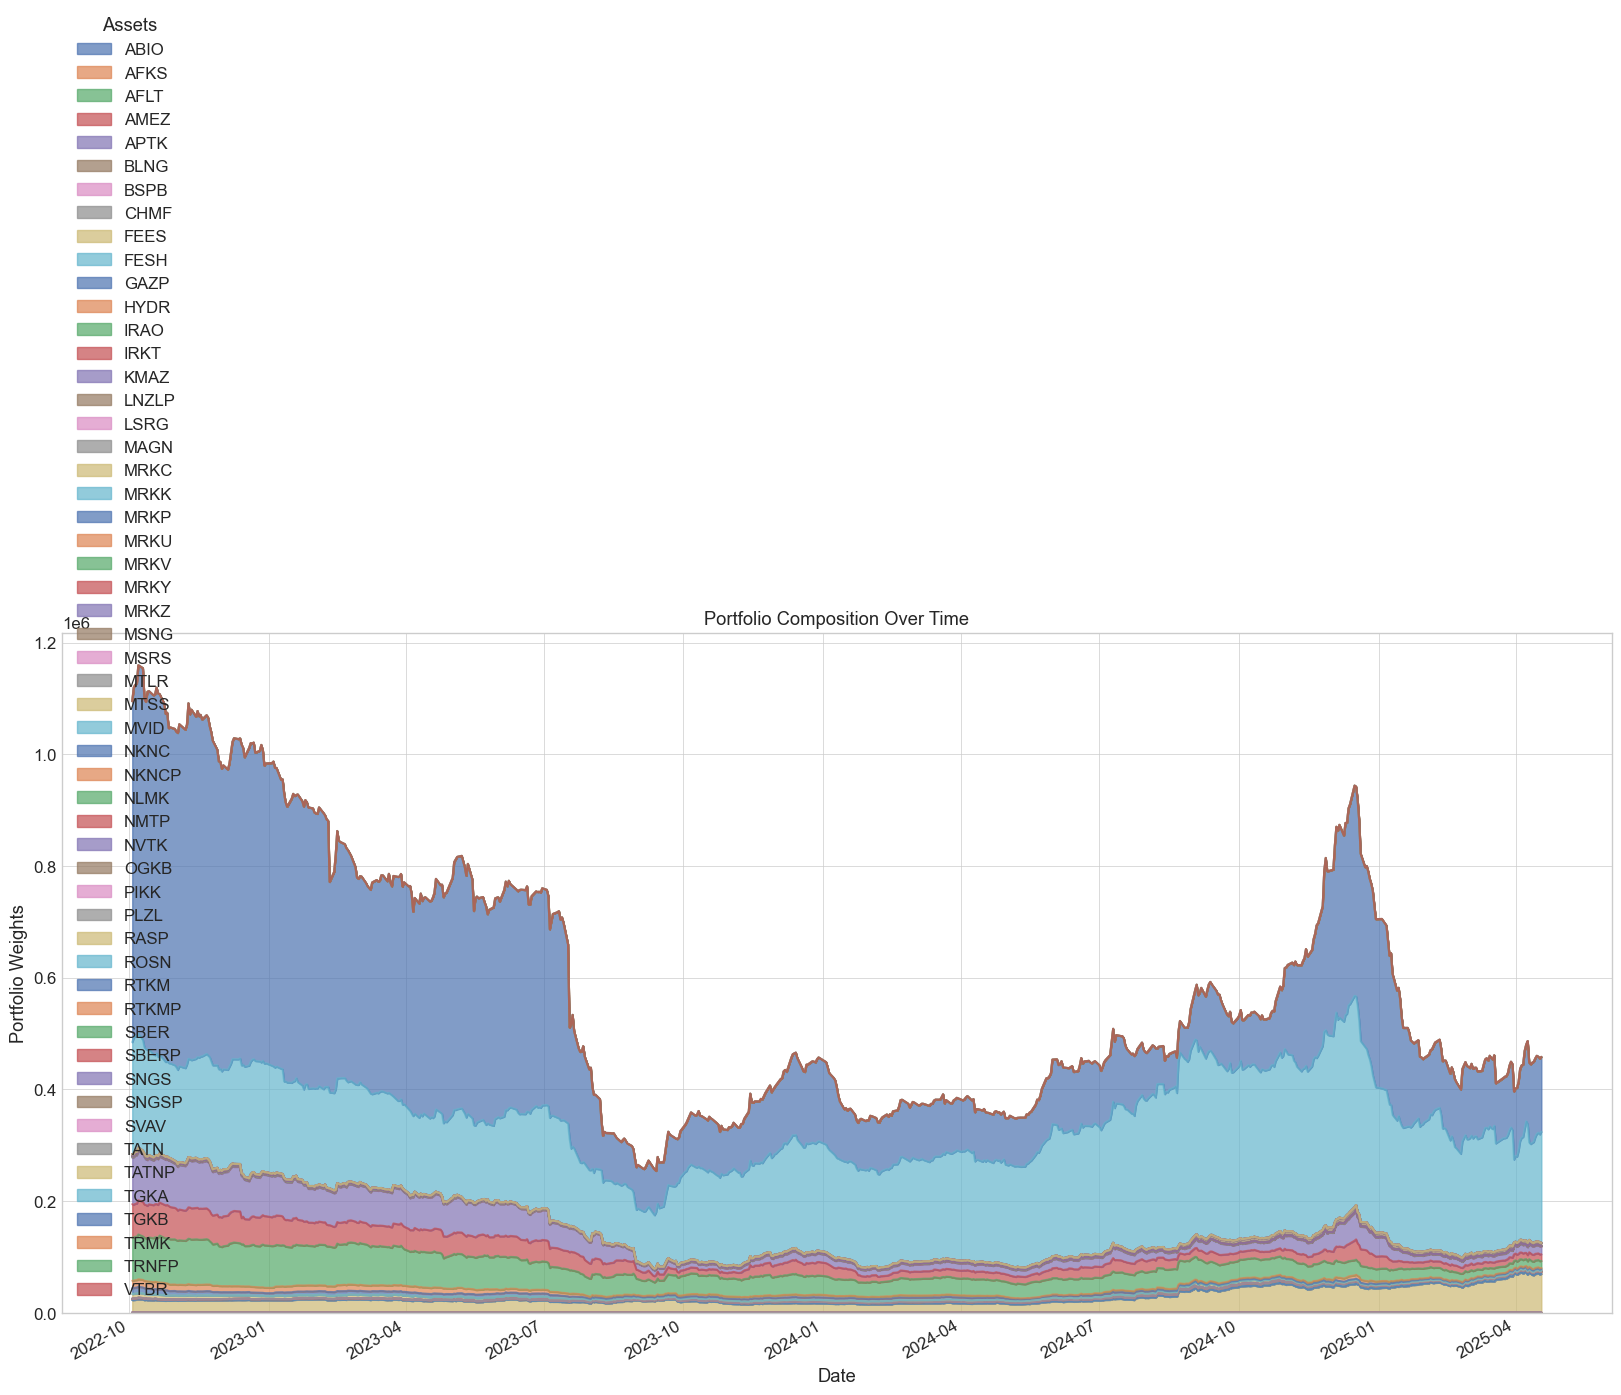

In [95]:

shares_discrete.loc['2022-10-01':][variance_filter].plot(kind="area", stacked=True, figsize=(20, 10), alpha=0.7)

# Настройка графика
plt.title("Portfolio Composition Over Time")
plt.ylabel("Portfolio Weights")
plt.xlabel("Date")
plt.legend(title="Assets")
plt.show()


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-whitegrid')



# Основная функция для расчета доходности портфеля
def calculate_portfolio_performance(quantities_df, prices_df, top_n_assets=10):
    """
    Рассчитывает доходность портфеля на основе данных о количестве и ценах акций.
    """

   
    
    # Проверяем, что у нас есть общие колонки
    common_tickers = set(quantities_df.columns) & set(prices_df.columns)
    if not common_tickers:
        raise ValueError("Нет общих тикеров между данными о количестве и ценах")
    
    # Оставляем только общие тикеры
    quantities_df = quantities_df[list(common_tickers)]
    prices_df = prices_df[list(common_tickers)]
    
    # Создаем DataFrame для стоимости каждой позиции (количество * цена)
    portfolio_value_by_ticker = pd.DataFrame(index=quantities_df.index)
    
    for ticker in common_tickers:
        # Для каждого дня умножаем количество акций на цену
        portfolio_value_by_ticker[ticker] = quantities_df[ticker] * prices_df[ticker]
    
    # Рассчитываем общую стоимость портфеля на каждый день
    total_portfolio_value = portfolio_value_by_ticker.sum(axis=1)
    
    # Рассчитываем относительную доходность портфеля
    initial_value = total_portfolio_value.iloc[0]
    portfolio_return = (total_portfolio_value / initial_value - 1) * 100
    
    # Рассчитываем относительную доходность по каждому тикеру
    ticker_returns = pd.DataFrame(index=portfolio_value_by_ticker.index)
    
    for ticker in common_tickers:
        initial_ticker_value = portfolio_value_by_ticker[ticker].iloc[0]
        if initial_ticker_value > 0:
            ticker_returns[ticker] = (portfolio_value_by_ticker[ticker] / initial_ticker_value - 1) * 100
        else:
            ticker_returns[ticker] = 0
    
    # Рассчитываем вклад каждого тикера в общую доходность
    initial_portfolio_value = total_portfolio_value.iloc[0]
    ticker_contribution = pd.DataFrame(index=portfolio_value_by_ticker.index)
    
    for ticker in common_tickers:
        ticker_contribution[ticker] = (portfolio_value_by_ticker[ticker] - portfolio_value_by_ticker[ticker].iloc[0]) / initial_portfolio_value * 100
    
    # Создаем summary DataFrame с основными показателями
    summary = pd.DataFrame({
        'Initial Value': portfolio_value_by_ticker.iloc[0],
        'Final Value': portfolio_value_by_ticker.iloc[-1],
        'Return (%)': ((portfolio_value_by_ticker.iloc[-1] / portfolio_value_by_ticker.iloc[0] - 1) * 100).fillna(0),
        'Weight (%)': (portfolio_value_by_ticker.iloc[0] / initial_portfolio_value * 100)
    })
    
    # Сортируем по весу
    summary = summary.sort_values('Weight (%)', ascending=False)
    
    # Получаем топ-N тикеров по весу
    top_tickers = summary.iloc[:top_n_assets].index.tolist()
    
    return {
        'portfolio_value': total_portfolio_value,
        'portfolio_return': portfolio_return,
        'ticker_returns': ticker_returns,
        'ticker_contribution': ticker_contribution,
        'portfolio_value_by_ticker': portfolio_value_by_ticker,
        'summary': summary,
        'top_tickers': top_tickers
    }

# Функция для визуализации результатов
def visualize_portfolio_performance(performance_results, figsize=(14, 20)):
    """
    Визуализирует результаты расчета доходности портфеля.
    """
    portfolio_return = performance_results['portfolio_return']
    ticker_returns = performance_results['ticker_returns']
    top_tickers = performance_results['top_tickers']
    summary = performance_results['summary']
    ticker_contribution = performance_results['ticker_contribution']
    
    # Создаем subplot grid
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(4, 2)
    
    # 1. График общей доходности портфеля
    ax1 = fig.add_subplot(gs[0, :])
    portfolio_return.plot(ax=ax1, linewidth=2.5, color='blue')
    ax1.set_title('Общая доходность портфеля', fontsize=14)
    ax1.set_ylabel('Доходность, %')
    ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax1.grid(True)
    
    # 2. График доходности топ-N тикеров
    ax2 = fig.add_subplot(gs[1, :])
    for ticker in top_tickers[:20]:  # Показываем только топ-5 для читаемости
        ticker_returns[ticker].plot(ax=ax2, label=ticker)
    ax2.set_title('Доходность топ-20 активов', fontsize=14)
    ax2.set_ylabel('Доходность, %')
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax2.legend()
    ax2.grid(True)
    
    # 3. Распределение активов в портфеле (начальное)
    ax3 = fig.add_subplot(gs[2, 0])
    summary.iloc[:20][['Weight (%)']].plot(kind='barh', ax=ax3)
    ax3.set_title('Топ-20 активов по весу в портфеле', fontsize=14)
    ax3.set_xlabel('Вес, %')
    ax3.grid(True)
    
    # 4. Распределение доходности по активам
    ax4 = fig.add_subplot(gs[2, 1])
    summary.iloc[:20][['Return (%)']].plot(kind='barh', ax=ax4)
    ax4.set_title('Доходность топ-20 активов', fontsize=14)
    ax4.set_xlabel('Доходность, %')
    ax4.grid(True)
    
    # 5. Вклад каждого актива в общую доходность
    ax5 = fig.add_subplot(gs[3, :])
    for ticker in top_tickers[:20]:  # Показываем только топ-5 для читаемости
        ticker_contribution[ticker].plot(ax=ax5, label=ticker)
    ax5.set_title('Вклад топ-20 активов в общую доходность', fontsize=14)
    ax5.set_ylabel('Вклад в доходность, %')
    ax5.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax5.legend()
    ax5.grid(True)
    
    plt.tight_layout()
    return fig

# Главная функция для выполнения всех расчетов и визуализации


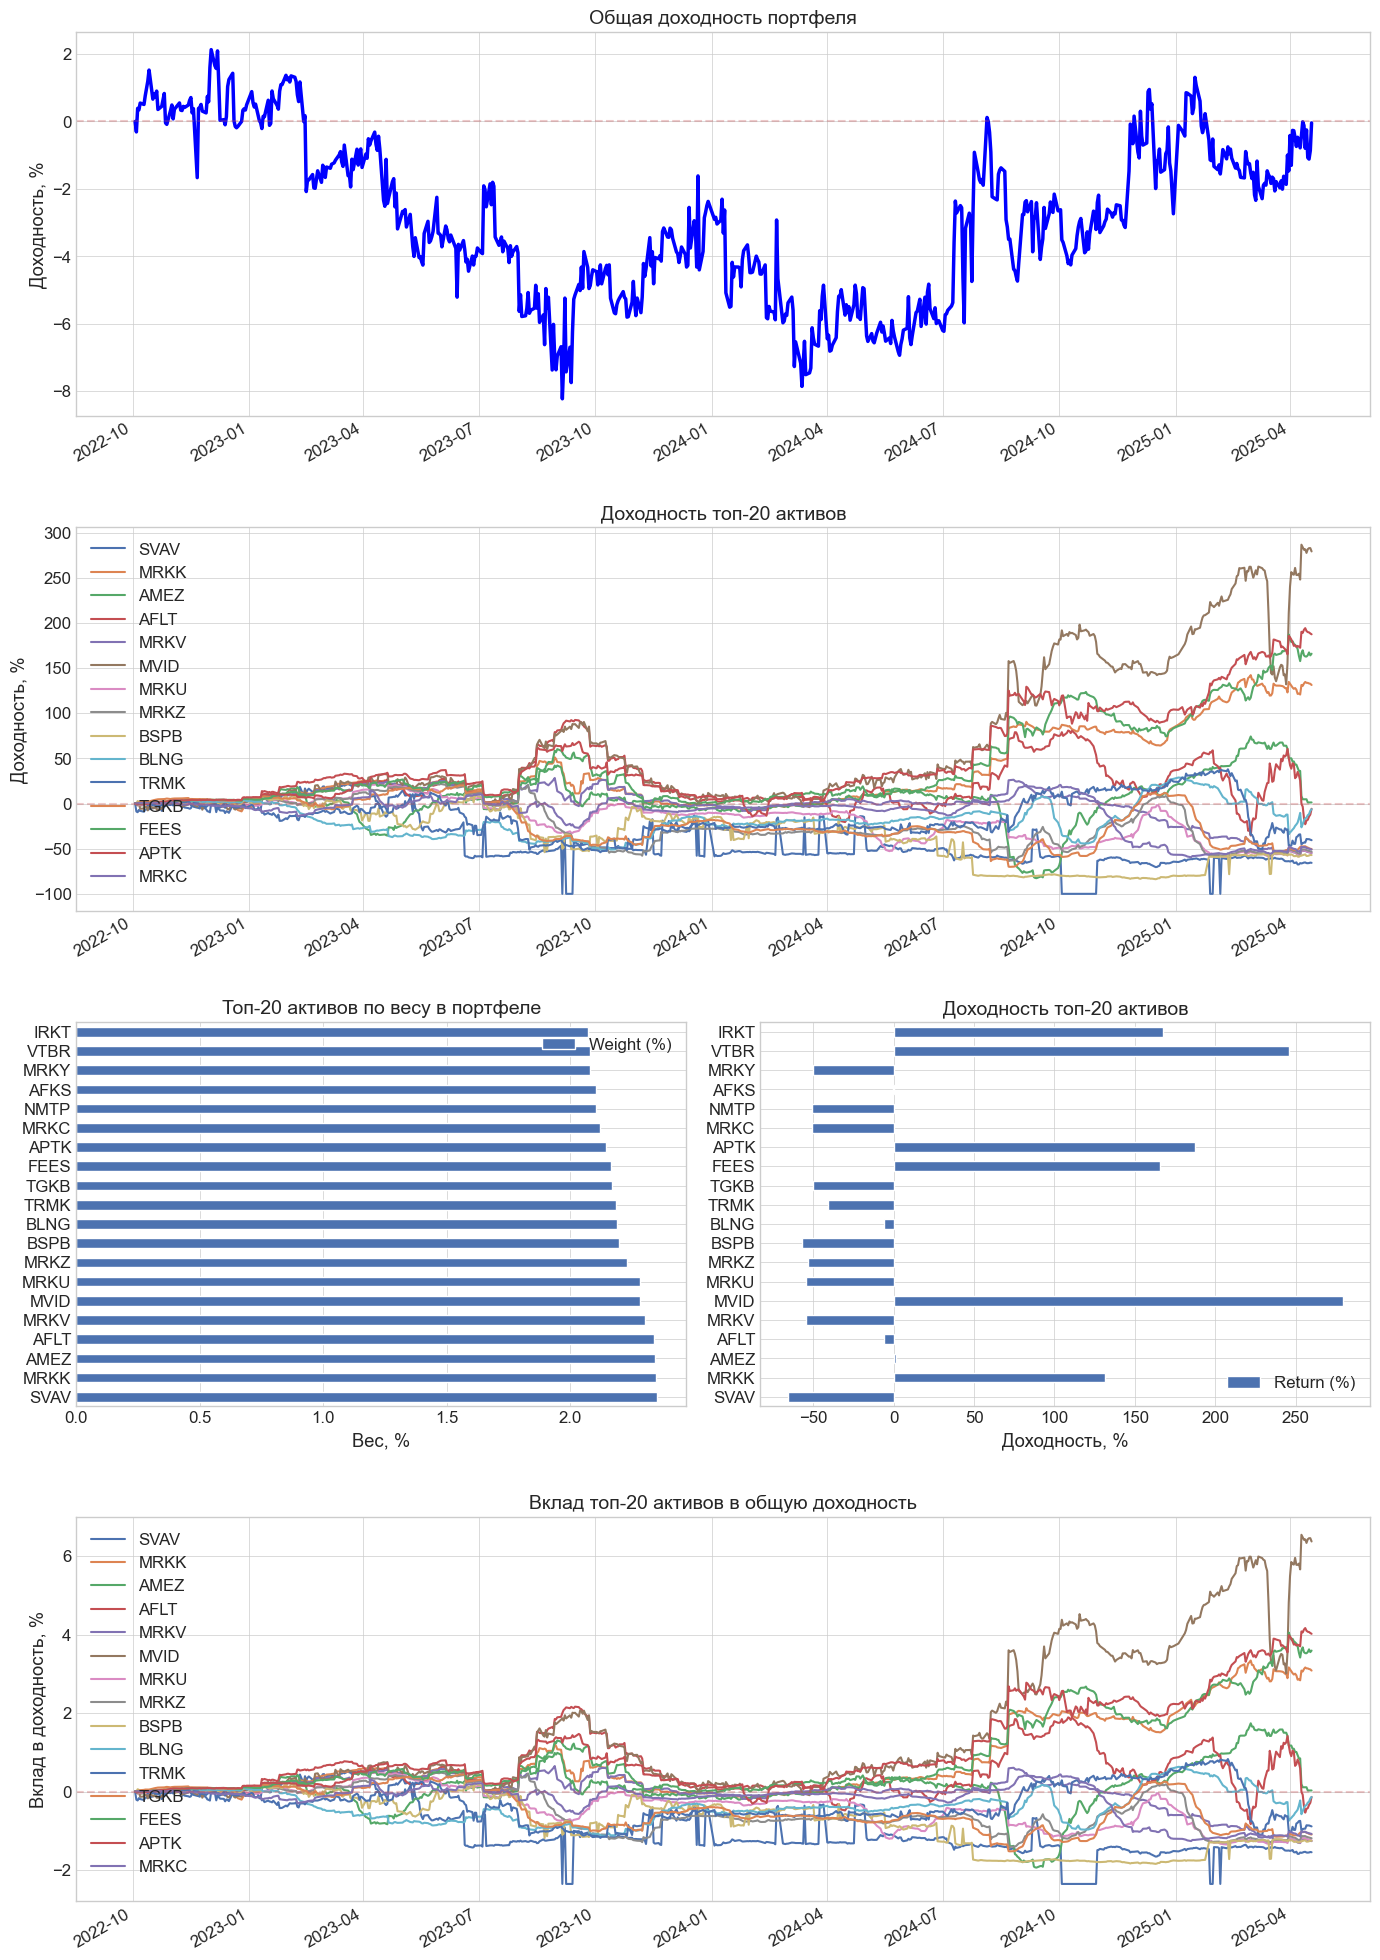

In [96]:
summary=calculate_portfolio_performance(shares_discrete.loc['2022-10-01':][variance_filter],prices.loc['2022-10-01':][variance_filter],top_n_assets=15)
fig=visualize_portfolio_performance(summary)

In [45]:
a=summary['summary']['Return (%)'].sort_values(ascending=False)


<Axes: >

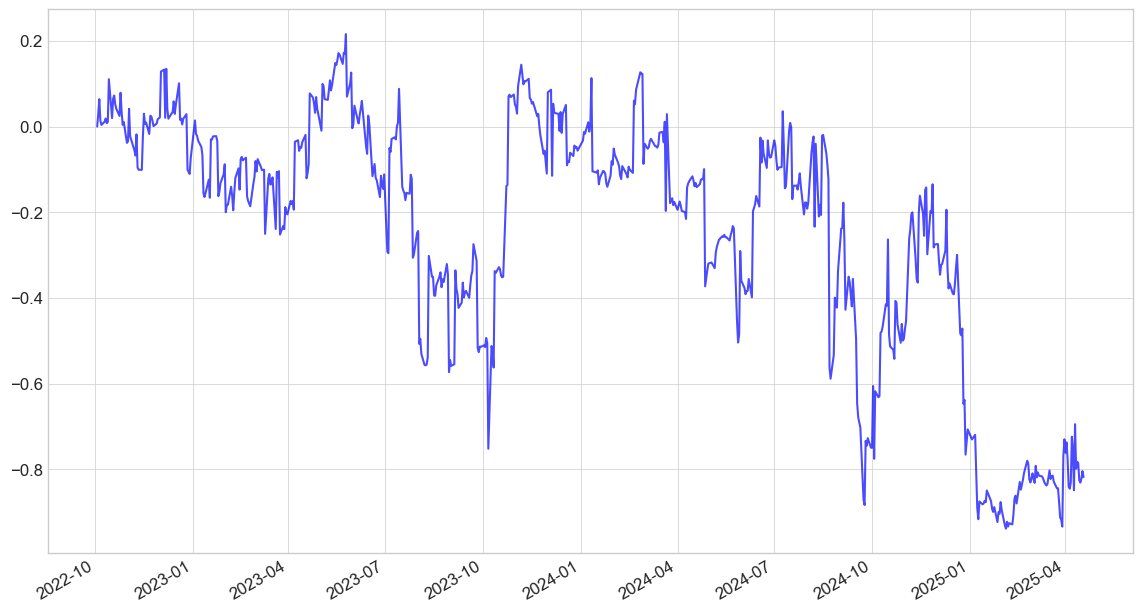

In [97]:
summary['ticker_contribution']['NLMK'].plot( figsize=(14, 8), color='blue', alpha=0.7)

In [48]:
a

RTKM              inf
HYDR              inf
NLMK              inf
RTKMP             inf
NKNC              inf
RASP              inf
ABIO              inf
GAZP              inf
NKNCP             inf
PIKK              inf
LNZLP             inf
SNGS              inf
OGKB     1.391726e+05
TGKA     2.578360e+04
MSRS     6.417446e+03
MTLR     4.860589e+03
IRAO     4.275232e+03
IRKT     3.726477e+03
MSNG     2.621727e+03
MAGN     1.810769e+03
KMAZ     1.763158e+03
FEES     1.433668e+03
APTK     1.363950e+03
MVID     8.653190e+02
VTBR     7.767250e+02
AFKS     7.563630e+02
BLNG     3.477930e+02
FESH     2.309110e+02
TRMK     1.872555e+02
TGKB     3.780200e+01
TATN     0.000000e+00
CHMF     0.000000e+00
PLZL     0.000000e+00
NVTK     0.000000e+00
SBER     0.000000e+00
TATNP    0.000000e+00
ROSN     0.000000e+00
SBERP    0.000000e+00
TRNFP    0.000000e+00
MTSS     0.000000e+00
LSRG     0.000000e+00
NMTP    -1.722693e+01
MRKK    -1.924506e+01
MRKP    -3.691641e+01
MRKY    -6.225383e+01
MRKZ    -6

In [49]:
a[~np.isinf(a)]

OGKB     139172.634157
TGKA      25783.601145
MSRS       6417.446340
MTLR       4860.588889
IRAO       4275.231567
IRKT       3726.477404
MSNG       2621.727273
MAGN       1810.769231
KMAZ       1763.157895
FEES       1433.668455
APTK       1363.950228
MVID        865.319015
VTBR        776.724960
AFKS        756.363003
BLNG        347.792998
FESH        230.910973
TRMK        187.255527
TGKB         37.802000
TATN          0.000000
CHMF          0.000000
PLZL          0.000000
NVTK          0.000000
SBER          0.000000
TATNP         0.000000
ROSN          0.000000
SBERP         0.000000
TRNFP         0.000000
MTSS          0.000000
LSRG          0.000000
NMTP        -17.226930
MRKK        -19.245059
MRKP        -36.916415
MRKY        -62.253829
MRKZ        -62.685032
MRKC        -65.399877
MRKV        -71.118581
AMEZ        -72.243943
MRKU        -74.463259
AFLT        -82.198904
BSPB       -100.000000
SNGSP      -100.000000
SVAV       -100.000000
Name: Return (%), dtype: float64

In [42]:
shares_discrete

,ABIO,AFKS,AFLT,AKRN,AMEZ,APTK,BLNG,BSPB,CHMF,CHMK,...,SNGSP,SVAV,TATN,TATNP,TGKA,TGKB,TRMK,TRNFP,VSMO,VTBR
2011-11-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-14,2.0,131.0,26.0,0.0,45.0,831.0,130.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,188013.0,142913.0,9.0,0.0,0.0,120.0
2025-04-15,2.0,152.0,32.0,0.0,43.0,802.0,130.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,190217.0,144188.0,9.0,0.0,0.0,112.0
2025-04-16,2.0,144.0,31.0,0.0,42.0,783.0,131.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,189925.0,146744.0,10.0,0.0,0.0,107.0
2025-04-17,2.0,139.0,30.0,0.0,42.0,776.0,137.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,188571.0,153213.0,10.0,0.0,0.0,102.0


In [1]:
prices.reset_index()[['datetime']].head(10)

NameError: name 'prices' is not defined

## Считаем в деньгах 

In [31]:

# Считаем стоимость каждой позиции: количество акций * цена
asset_values = shares_discrete * prices[stock_columns]

# asset_values — DataFrame: индексы — даты, столбцы — тикеры, значения — сумма средств в каждом активе
print(asset_values.head())

            ABIO  AFKS  AFLT  AKRN  AMEZ  APTK  BLNG  BSPB  CHMF  CHMK  ...  \
2011-11-17   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2011-11-18   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2011-11-21   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2011-11-22   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2011-11-23   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

            SNGSP  SVAV  TATN  TATNP  TGKA  TGKB  TRMK  TRNFP  VSMO  VTBR  
2011-11-17    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  
2011-11-18    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  
2011-11-21    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  
2011-11-22    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  
2011-11-23    0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   0.0   0.0  

[5 rows x 61 columns]


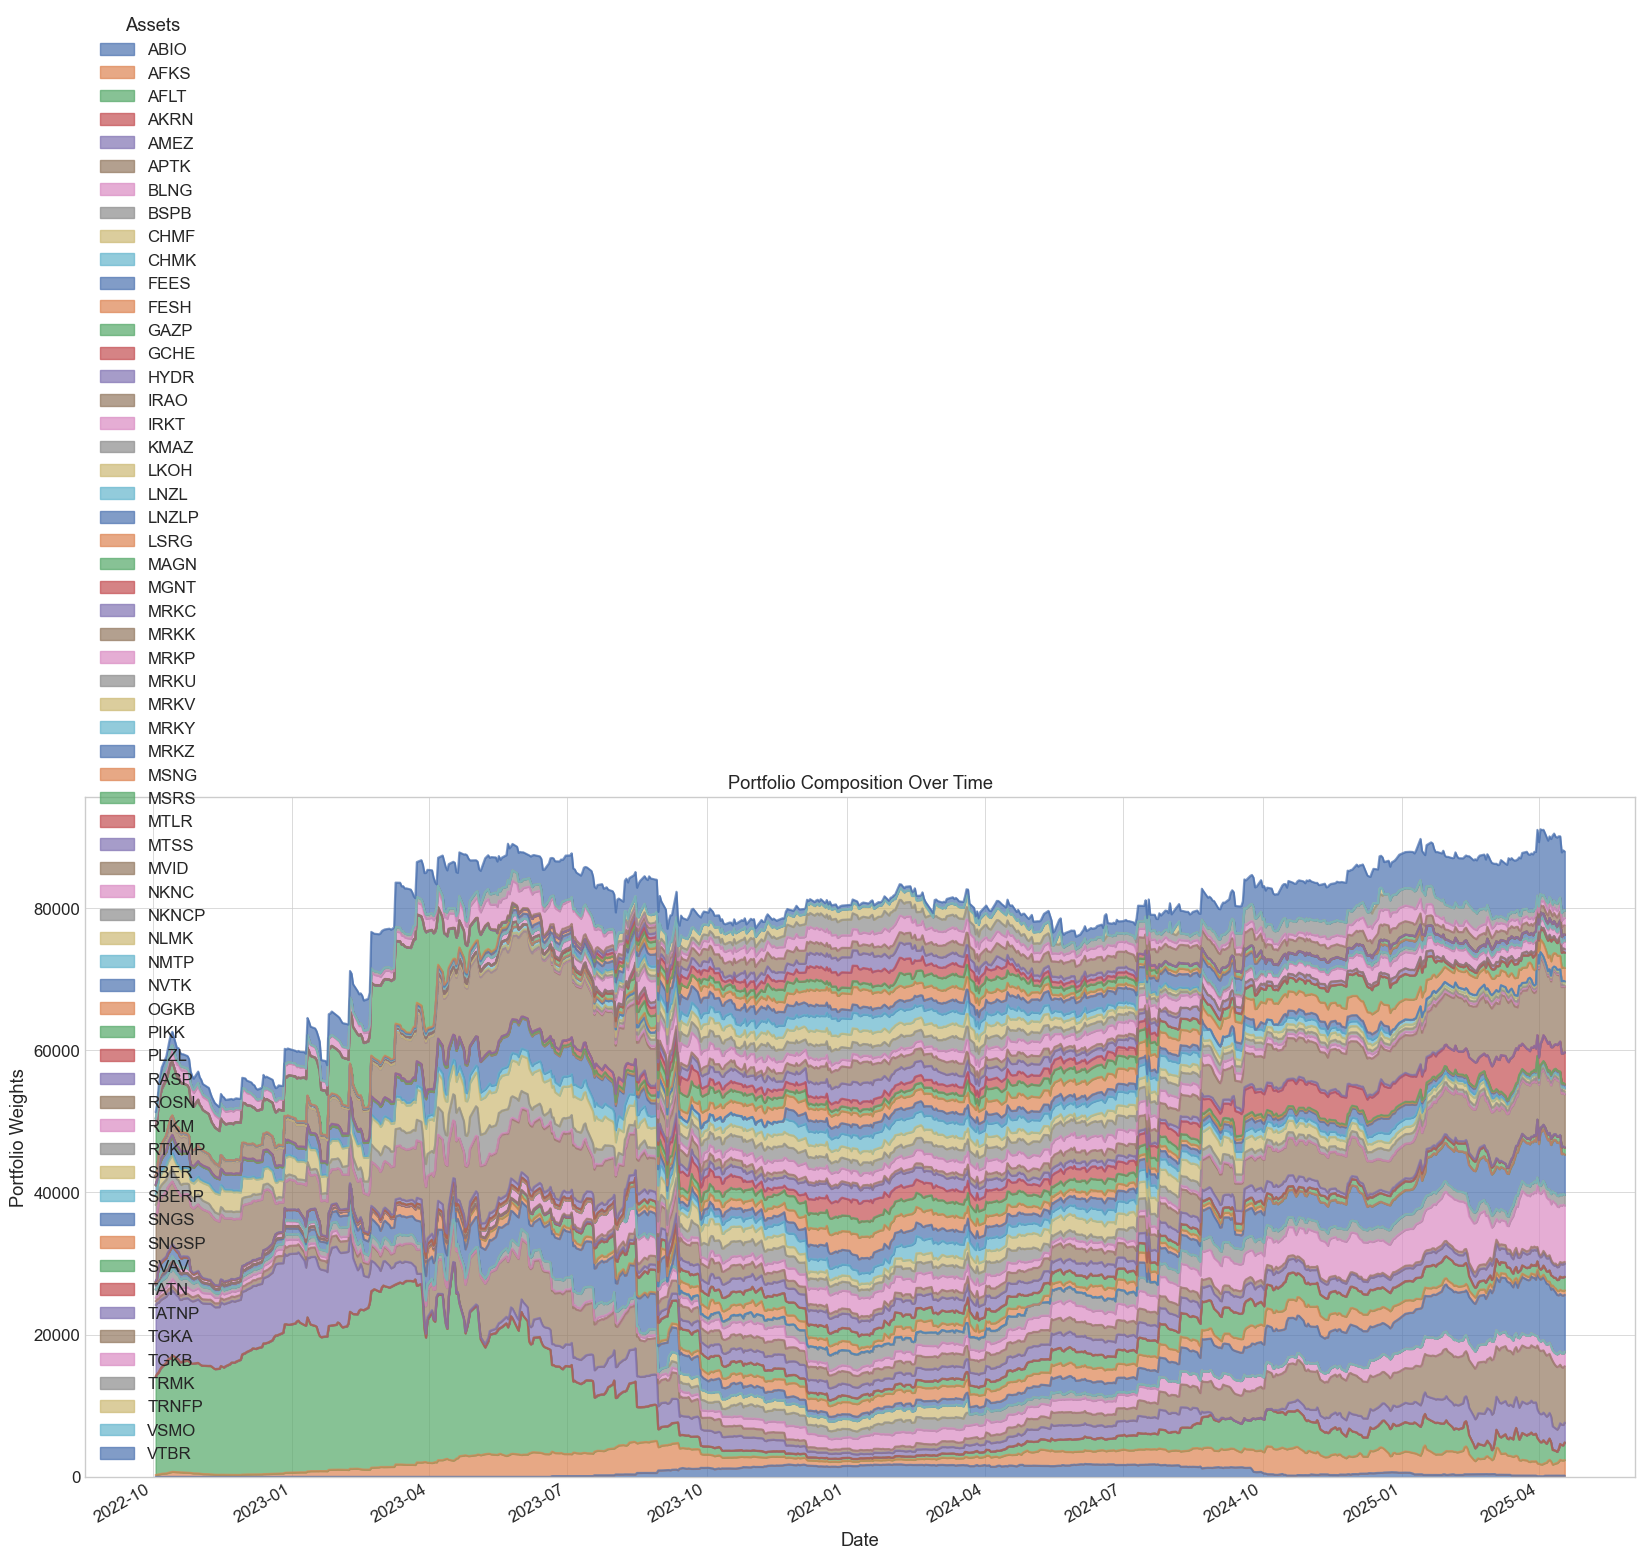

In [98]:


asset_values.loc['2022-10-01':].plot(kind="area", stacked=True, figsize=(20, 10), alpha=0.7)

# Настройка графика
plt.title("Portfolio Composition Over Time")
plt.ylabel("Portfolio Weights")
plt.xlabel("Date")
plt.legend(title="Assets")
plt.show()


In [99]:

june_2024 = shares_discrete.loc["2024-06-14":"2024-06-17"]

# Считаем среднюю долю каждой акции за месяц (без Cash)
mean_weights = june_2024.mean().sort_values(ascending=False)

# Топ-10 акций по средней доле
top10 = mean_weights.head(10)
print("Топ-10 акций в портфеле в июне 2024:")
print(top10)

Топ-10 акций в портфеле в июне 2024:
TGKA    221547.5
TGKB    111581.0
MRKV     28199.5
FEES     19418.5
MRKY     17839.5
MRKZ     15195.0
OGKB      3753.0
MRKP      3702.0
HYDR      2878.5
MRKC      2820.0
dtype: float64


In [34]:
# ...existing code...

# Фильтруем только июнь 2024
june_2024 = actions_df.loc["2024-06-14":]

# Считаем среднюю долю каждой акции за месяц (без Cash)
mean_weights = june_2024.mean().sort_values(ascending=False)

# Топ-10 акций по средней доле
top10 = mean_weights.head(10)
print("Топ-10 акций в портфеле в июне 2024:")
print(top10)
# ...existing code...

Топ-10 акций в портфеле в июне 2024:
MVID     0.055507
VTBR     0.053330
FEES     0.051674
APTK     0.051643
LNZLP    0.050582
MRKK     0.050497
IRKT     0.048550
AFLT     0.033933
MTLR     0.031922
LNZL     0.028193
dtype: float32
